# 1 An introduction to remote services and multi-agent systems

In the previous session, you had an opportunity to experiment hands-on with some neural networks. You may have finished that lab session wondering how neural networks can be built into real robots, particularly low-cost robots rather than expensive cutting-edge robots found only in research labs. In this session, you will find out.

The robot simulator we're using was originally designed to simulate the behaviour of a Lego Mindstorms EV3 controlled robot. The EV3 brick is excellent for introductory robotics, but it has limitations in terms of processor speed and memory capacity. This makes it impractical to train anything other than a small neural network on a Lego EV3 robot, although we may be able to use pre-trained models to perform "on-device" classification tasks.

In general, we are often faced with the problem that we may want to run powerful programs on low-cost hardware that really isn't up to the job. Upgrading a robot with a more powerful processor might not be a solution because it adds cost and may demand extra electrical power or create heat management issues: driving a processor hard can generate a lot of heat, and you need to remove that heat somehow. Heatsinks are heavy and take up physical space, and cooling fans are heavy, take up space, and need access to power. As you add more mass, you need more powerful motors, which themselves add mass and require more power. Bigger batteries add more mass, so you can see where this argument leads...

A possible alternative is to think about using remote services or *multi-agent* systems approaches. In either case, we might use a low-cost robot as a mobile agent to gather data and send that back to a more powerful computer for processing.

In the first case, we might think of the robot as a remote data collector, collecting data on our behalf and then returning that data to us in response to a request for it. In the RoboLab environment we might think of the notebook Python environment as our local computing environment and the robot as a remote service. Every so often, we might *pull* data from the robot by making a request for a copy of it from the notebook so that we can then analyse the data at our leisure. Alternatively, each time the robot collects a dataset, it might *push* a copy of the data to the notebook's Python environment. In each case, we might think of this as "uploading" data from the simulated robot back to the notebook.

In a more dynamic multi-agent case we might consider the robot and the notebook environment to be acting as peers sending messages as and when they can between each other. For example, we might have two agents: a Lego mobile robot and a personal computer (PC), or the simulated robot and the notebook. We let the robot do what it does best – move around while logging data – and then it actively sends the data back to the PC for processing. The PC processes the data using a trained neural network, or perhaps a complex rule based system, and sends back a message to the robot giving an appropriate response. In each case, the two agents act independently, sending messages to the other party when they have data or a classification to share, rather than just responding to requests for data or a particular service as thy occur.

In this session, we will explore how we might use the simulated robot as a remote data collector. Every so often, we will grab a copy of the logged data into the notebook Python environment and analyse it within the notebook.

*There is quite a lot of provided code in this notebook. You are not necessarily expected to be able to create this sort of code yourself. Instead, try to focus on the process of how various tasks are broken down into smaller discrete steps, as well as how small code fragments can be combined to create "higher level" functions that perform ever more powerful tasks.*

## 1.1 Using a pre-trained MLP to categorise light sensor array data logged from the simulator

The *MNIST_Digits* simulator background includes various digit images from the MNIST dataset, arranged in a grid.

Alongside each digit is a grey square, where the grey level is used to encode the actual label associated with the image. (You can see how the background was created in the `Background Image Generator.ipynb` notebook.)

In this notebook, you will use the light sensor as a simple low resolution camera, working with the pixel array data rather then the single value reflected light value.

*Note that this functionality is not supported by the real Lego light sensor.*

Let's start by loading in the simulator:

In [1]:
from nbev3devsim.load_nbev3devwidget import roboSim, eds

%load_ext nbev3devsim

<IPython.core.display.Javascript object>

Ev3DevWidget(status='deferring flush until render')

In order to collect the sensor image data, if the simulated robot program `print()` message starts with the word `image_data`, then we can send light sensor array data from the left, right or both light sensorts to a data log in the notebook Python environment.

The `-R` switch in magic at the start of the following code cell will run the program in the simulator once it has been downloaded.  

In [5]:
%%sim_magic_preloaded -b MNIST_Digits -OA -R -x 400 -y 50

# Configure a light sensor
colorLeft = ColorSensor(INPUT_2)

#Sample the light sensor reading
sensor_value = colorLeft.reflected_light_intensity

# This is a command invocation rather than a print statement
print("image_data left")
# The command is responded to by
# the "Image data logged..." message display

As we're going to be collecting data from the simulator into the notebook Python enviornment, we should take the precaution of clearing the notebook datalog before we start using it:

In [6]:
%sim_data --clear

### 1.1.1 Pushing the sensor array data log from the simulator to the notebook

We can now run the data collection routine by calling a simple line magic that teleports the robot to a specific location, runs the data collection program (`-R`) and pushes the light sensor array data to the notebook Python environment:

In [7]:
%sim_magic -RA -x 400 -y 850

# Wait a moment to give data time to synchronise
import time
time.sleep(1)

We may need to wait a few moments for the program to execute and the data to be sent to the notebook Python environment.

In the current example, the simulator is *pushing* the light sensor array data to the notebook each time the robot sends a particular message to the simulator output window.

With the data pushed from the simulator to the notebook Python environment, we should be able to see a dataframe containing the retrieved data:

In [8]:
roboSim.image_data()

,side,vals,clock
0,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1


### 1.1.2 Previewing the sampled sensor array data (optional)

Having grabbed the data, we can explore the data as rendered images.

The data representing the image is a long list of RGB (red green, blue) valaues. We can generate an image from a the a specific row of the dataframe, given it the row index:

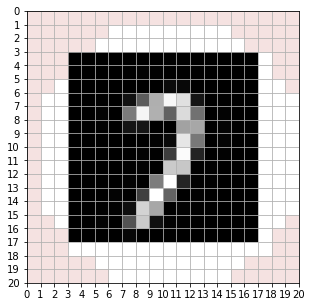

In [9]:
from nn_tools.sensor_data import generate_image, zoom_img
index = -1 # Get the last image in the dataframe

img = generate_image(roboSim.image_data(),
                     index, mode='rgb')
zoom_img(img)

If you don't see a figure image displayed, check that the robot is placed over a figure by reviewing the sensor array display in the simulator. If the image is there, rerun the previous code cell to see if the data is now available. If it isn't, rerun the data collecting magic cell, wait a view seconds, and then try to view the zoomed image display.

We can check the color depth of the image by calling the `.getbands()` method on it:

In [10]:
img.getbands()

('R', 'G', 'B')

As we might expect from the robot color sensor, this is a tri-band, RGB image.

Alternatively, we can generate an image directly as a greyscale image, either by setting the mode explicity or by omitting it (`mode=greyscale` is the default setting):

('L',)

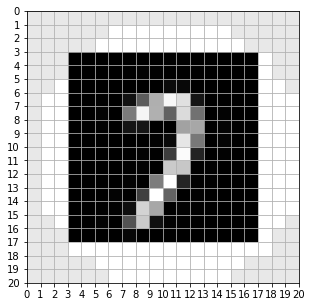

In [11]:
img = generate_image(roboSim.image_data(), index)
zoom_img(img)

img.getbands()

The images we trained the network on were size 28 x 28 pixels. The raw images retrieved from the simulator sensor are slightly smaller, coming in at 20 x 20 pixels.

In [12]:
img.size

(20, 20)

The collected image also represents square profile around the "circular" sensor view. We might thus reasonably decide that we are going to focus our attention on the 14 x 14 square area in the centre of the collected image, with top left pixel `(3, 3)`.

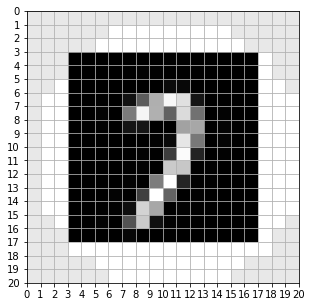

In [13]:
zoom_img(img)

One of the advantages of using the Python `PIL` package is that a range of *methods* (that is, *functions*) are defined on each image object that allow us to manipulate it *as an image*. (We can then also access the data defining the transformed image *as data* if we need it in that format.)

We can preview the area in our sampled image by cropping the image to the area of interest:

(14, 14)

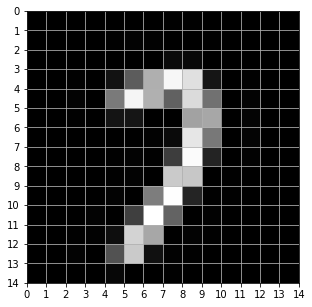

In [14]:
img = generate_image(roboSim.image_data(), index,
                    crop=(3, 3, 17, 17))

display(img.size)
zoom_img( img )

If required, we can resize the image by passing the desired size to the `generate_image()` function via the `resize` parameter, setting it either to a specified size, such as `resize=(28, 28)` (that is, 28 x 28 pixels) or back to the original, uncropped image size (`resize=('auto')`)

```python

img = generate_image(roboSim.image_data(), index,
                    crop=(3, 3, 17, 17),
                    resize = (28, 28))
```

### 1.1.3 Collecting multiple sample images

The handwritten digit image sampling point locations in the *MINIST_Digits* simulator background can be found at the following locations:

- along rows `100` pixels apart, starting at `x=100` and ending at `x=2000`;
- along columns `100` pixels apart, starting at `y=50` and ending at `y=1050`.

We can collect the samples collected over a column by using line magic to teleport the simulated robot to each new location in turn and automatically run the program to log the sensor data.

To start, let's just check we can generate the required *y* values:

In [15]:
# Generate a list of integers with desired range and gap
min_value = 50
max_value = 1050
step = 100

list(range(min_value, max_value+1, step))

[50, 150, 250, 350, 450, 550, 650, 750, 850, 950, 1050]

Using this as a pattern, we can now create a simple script to clear the datalog, then iterate throug the desired *y* locations, using line magic to locate the robot at each step and run the already downloaded image sampling program.

To access the value of the iterated *y* value in the magic, we need to prefix it with a `$` when we refer to it. Note that we also use the `tqdm.notebook.trange` argument to define the range: this enhance the range iterator to provide an interactive progress bar that allows us to follw the progress of the iterator.

In [16]:
# Provide a progress bar when iterating through the range
from tqdm.notebook import trange

# We need to add a short delay between iterations to give
# the data time to synchronise
import time

# Clear the datalog so we know it's empty
%sim_data --clear

for _y in trange(min_value, max_value+1, step):
    %sim_magic -R -x 100 -y $_y
    # Give the data time to synchronise
    time.sleep(1)

We can view the collected samples via a *pandas* dataframe:

In [17]:
image_data_df = roboSim.image_data()
image_data_df

,side,vals,clock
0,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
1,left,"245,226,225,245,226,225,245,226,225,245,226,22...",2
2,left,"245,226,225,245,226,225,245,226,225,245,226,22...",2
3,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
4,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
5,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
6,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
7,left,"245,226,225,245,226,225,245,226,225,245,226,22...",2
8,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
9,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1


We can access a centrally cropped black and white version of an image extracted from the retrieved data by index number  (`--index / -i`) by calling the `%sim_bw_image_data` magic, optionally setting the `--threshold / -t` value away from its default value of `127`. Using the `--nocrop / -n` flag will prevent the autocropping.

We can  convert the image to a black and white image by setting pixels above a specified threshold value to white (`255`), otherwise coloring the pixel black (`0`).

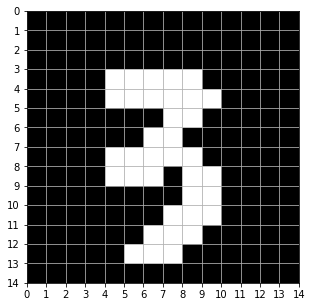

In [18]:
cropped_bw_image = %sim_bw_image_data --index -1 --threshold 100
zoom_img(cropped_bw_image)

We can also retrieve a random image from the collected data using the `--random / -r` flag:

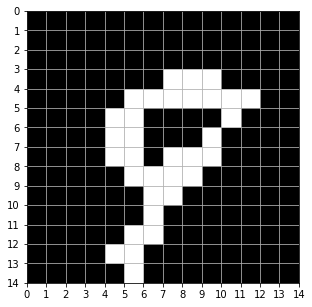

In [19]:
cropped_bw_image = %sim_bw_image_data --random --threshold 100
zoom_img(cropped_bw_image)

The `generate_bw_image()` function provides another way of generating such an image, as the code used to implement the end-user application in the following activity demonstrates. 

*End user applications are simple applications created by users themselves to simplify the performance of certain tasks. Such applications may be brittle and only work in specific situations or circumstances. The code may not be as elegant, well engineered or maintainable as "production code" used in applications made available to other users. One of the advantages of learning to code is the ability to create your own end-user applications.*

### 1.1.4 Activity — Observing the effect of changing threshold value when coverting the image from a greyscale to a black and white image (optional) 

Using the following end user application to observe the effects of setting different threshold values when creating the black and white binarised version of the image from the original greyscale image data.

In [21]:
from nn_tools.sensor_data import generate_bw_image
from ipywidgets import interact_manual

@interact_manual(threshold=(0, 255),
                 index=(0, len(image_data_df)-1))
def bw_preview(index=0, threshold=200,
               crop=False):
    # Optionally crop to the centre of the image
    _crop = (3, 3, 17, 17) if crop else None
    _original_img = generate_image(image_data_df, index)
    
    # Generate a black and white image
    _demo_img = generate_bw_image(image_data_df, index,
                                  threshold=threshold,
                                  crop=_crop)
    # %sim_bw_image_data --index -1 --threshold 100 --crop 3.3,17,17
    zoom_img( _original_img)
    zoom_img( _demo_img )

    # Preview the actual sized image
    # display(_original_img, _demo_img)

interactive(children=(IntSlider(value=0, description='index', max=10), IntSlider(value=200, description='thres…

*The `sensor_image_focus()` function is another convenience function for returning the image in the centre of the sensor array.*

```python
from nn_tools.sensor_data import sensor_image_focus

original_image = generate_image(image_data_df, index)
focal_image = sensor_image_focus( original_image )
zoom_img( focal_image )
```

## 1.2 Testing the robot sample images using a pre-retrained MLP

Having grabbed the image data, we can pre-process it as required and then present it to an appropriately trained neural network to see if the network can identify the digit it represents.

### 1.2.1 Loading in a previously saved MLP model

Rather than train a new model, we can load in an MLP we have trained previously. Remember, when using a neural network model, we need to make sure that we know how many inputs it expects, which in our case matches the size of presented images.

You can either use the pretrained model that is provided in the same directory as this notebook (`mlp_mnist.joblib`), or use your own model created in an earlier notebook.

In [22]:
# Load model
from joblib import load

MLP = load('mlp_mnist14x14.joblib')

Check the configuration of the MLP:

In [23]:
from nn_tools.network_views import network_structure
network_structure(MLP)

Number of input features: 196
Number of layers: 3
Number of outputs: 10
Hidden layer sizes: 10
Number of training iterations: 150


The 196 input features correspond to an input grid of 14x14 pixels.

*For a square array, we get the side length as the square root of the number of features.*

### 1.2.2 Using the pre-trained classifier to recognise sampled images

What happens if we now try to recognise images sampled from the simulator light sensor array using our previously trained MLP classifier?

Predicted label: 9


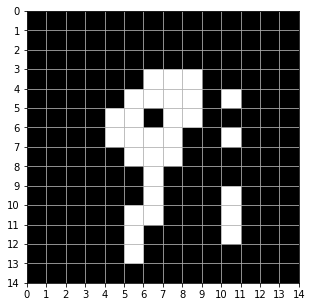

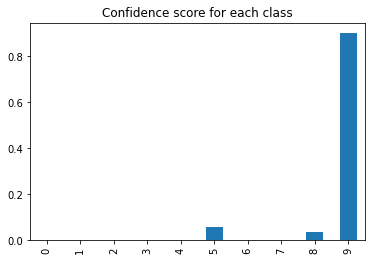

In [41]:
import random
from nn_tools.network_views import image_class_predictor

# Get a random image index value
index = random.randint(0, len(image_data_df)-1)
        
# Generate the test image as a black and white image
test_image = generate_bw_image(image_data_df, index,
                               threshold=127,
                               crop=(3, 3, 17, 17))

# Display a zoomed version of the test image
zoom_img(test_image)

# Print the class prediction report
image_class_predictor(MLP, test_image);

Predicted label: 2


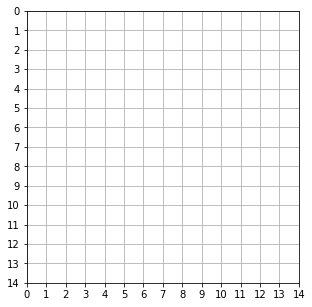

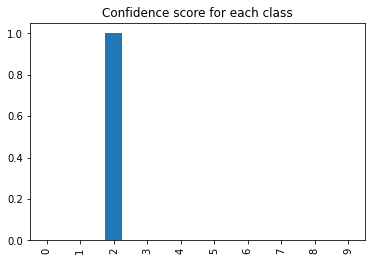

In [42]:
test_image2 = %sim_bw_image_data --index -1 
# Display a zoomed version of the test image
zoom_img(test_image2)

# Print the class prediction report
image_class_predictor(MLP, test_image2);

How well did the classifier perform?

*Make your own notes and observations about the MLP's performance here. If anything strikes you as unusual, why do you think the MLP is performing the way it is?*

We can create a simple interactive application to test the other images more easily:

In [43]:
@interact_manual(threshold=(0, 255),
                 index=(0, len(image_data_df)-1))
def test_image(index=0, threshold=200, show_image=True):
    # Create the test image
    test_image = generate_bw_image(image_data_df, index, 
                                   threshold=threshold,
                                   crop=(3, 3, 17, 17))
    
    # Generate class prediction chart
    image_class_predictor(MLP, test_image)
    
    if show_image:
        zoom_img(test_image)


interactive(children=(IntSlider(value=0, description='index', max=10), IntSlider(value=200, description='thres…

In general, how well does the classifier appear to perform?

*Record your own notes and observations about the behaviour and performance of the MLP here.*

### 1.2.3 Activity — Collecting image sample data at a specific location

Write a simple line magic command to collect the image data for the handwritten digit centred on the location `(600, 750)`.

Note that you may need to wait a short time between running the data collection program and trung to view it.

Display a zoomed version of the image in the notebook. By observation, what digit does it represent?

Using the `image_class_predictor()` function, how does the trained MLP classify the image? Does this match your observation?

Increase the light sensor noise in the simulator to its maximum value and collect and test the data again. How well does the network perform this time?


*Hint: data is collected into a dataframe returned by calling `roboSim.image_data()`.*

*Hint: remember that you need to crop the image to a 14x14 array.*

In [44]:
# Your image sampling code here


In [37]:
# Your image viewing code here


*From your own observation, record which digit is represented by the image here.*

In [38]:
# How does the trained MLP classify the image?


*How well does the prediction match your observation? Is the MLP confident in its prediction?*

Increase the level of light sensor noise to it's maximum value and rerun the experiment:

In [39]:
# Collect data with noise


In [40]:
# Preview image with noise


In [41]:
# Classify image with noise


*Your notes and observations on how well the network performed the classfication task in the presece of sensor noise.*

#### Example discussion

*Click on the arrow in the sidebar or run this cell to reveal an example discussion.*

We can collect the image data by calling the `%sim_magic` with the `-R` switch so that it runs the current program directly. We also need to set the location using the `-x` and `-y` parameters.

In [42]:
%sim_magic -R -x 600 -y 750

The data is available in a dataframe returned by calling `roboSim.image_data()`.

To view the result, we can zoom the display of the last collected image in the notebook synched datalog.

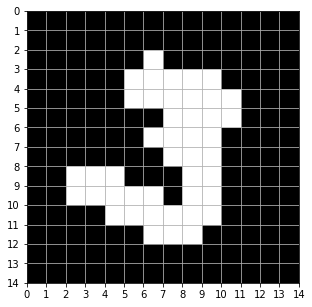

In [43]:
# Get data for the last image in the dataframe
index = -1 
my_img = generate_bw_image(roboSim.image_data(), index,
                        crop=(3, 3, 17, 17))
zoom_img(my_img)

By my observation, the digit represented by the image at the specified location is a figure `3`.

The trained MLP classifies the object as follows:

Predicted label: 3


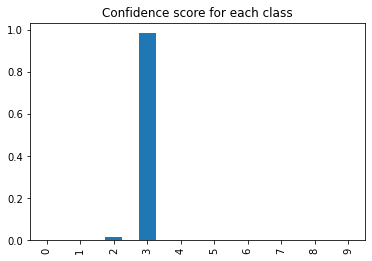

In [44]:
image_class_predictor(MLP, my_img)

This appears to match my prediction.

## 1.3 Collecting digit image and class data from the simulator

If you look carefully at the *MNIST_Digits* background in the simulator, you will see that alongside each digit is a solid coloured area. This area is a greyscale value that represents the value of the digit represented by the image. That is, it represents a training label for the digit.

Before we proceed, clear out the datalog to give ourselves a clean datalog to work with:

In [35]:
%sim_data --clear

The solid coloured areas are arranged so that when the left light sensor is over the image, the right sensor is over the training label area.

In [36]:
%%sim_magic_preloaded -b MNIST_Digits -O -R -AH -x 400 -y 50

#Sample the light sensor reading
sensor_value = colorLeft.reflected_light_intensity

# This is essentially a command invocation
# not just a print statement!
print("image_data both")

We can retrieve the last pair of images from the `roboSim.image_data()` dataframe using the `get_sensor_image_pair()` function:

(None, None)

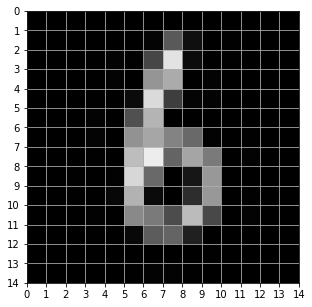

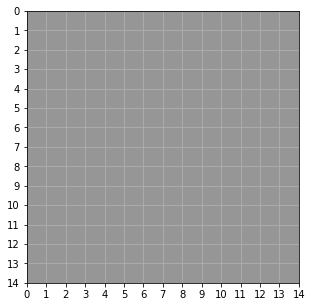

In [45]:
from nn_tools.sensor_data import get_sensor_image_pair

# The sample pair we want from the logged image data
pair_index = -1

left_img, right_img = get_sensor_image_pair(roboSim.image_data(),
                                            pair_index)

zoom_img(left_img), zoom_img(right_img)


The image labels are encoded as follows:

`greyscale_value = 25 * digit_value`

One way of decoding the label is as follows:

- divide each of the greyscale pixel values collected from the right hand sensor array by 25;
- take the median of these values and round to the nearest integer; *in a noise free environment, using the median should give a reasonable estimate of the dominant pixel value in the frame.*
- ensure we have an integer by casting the result to an integer.

The *pandas* package has some operators that can help us with that if we put all the data into a *pandas* *Series* (essentially, a single column dataframe):

In [46]:
import pandas as pd

def get_training_label_from_sensor(img):
    """Return a training class label from a sensor image."""
    # Get the pixels data as a pandas series
    # (similar to a single column dataframe)
    image_pixels = pd.Series(list(img.getdata()))

    # Divide each value in the first column (name: 0) by 25
    image_pixels = image_pixels / 25

    # Find the median value
    pixels_median = image_pixels.median()

    # Find the nearest integer and return it
    return int( pixels_median.round(0))

# Try it out
get_training_label_from_sensor(right_img)

6

The following function will grab right and left image from the data log, decode the label from the right hand image, and return the handwritten digit from the left light sensor along with the training label:

Label: 6


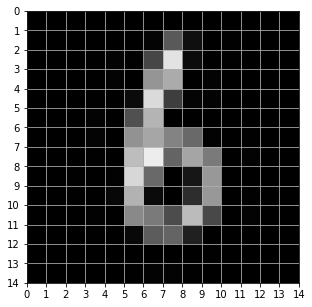

In [47]:
def get_training_data(raw_df, pair_index):
    """Get training image and label from raw data frame."""
    
    # Get the left and right images
    # at specified pair index
    left_img, right_img = get_sensor_image_pair(raw_df,
                                            pair_index)
    
    # Find the training label value as the median
    # value of the right habd image.
    # Really, we should properly try to check that
    # we do have a proper training image, for example
    # by encoding a recognisable pattern 
    # such as a QR code
    training_label = get_training_label_from_sensor(right_img)
    return training_label, left_img
    

# Try it out
label, img = get_training_data(roboSim.image_data(),
                               pair_index)
print(f'Label: {label}')
zoom_img(img)

We're actually taking quite a lot on trust in extracting the data from the dataframe in this way. Ideally, we would have a unique identifiers that reliably associate the left and right images as having been sampled from the same location. As it is, we assume the left and right image datasets appear in that order, one after the other, so we can count back up the dataframe to collect different pairs of data.

We can now test that image against the classifier:

Predicted label: 6


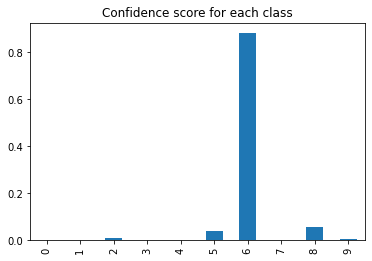

In [48]:
image_class_predictor(MLP, img)

### 1.3.1 Activity — Testing the ability to recognise images slight off-center in the image array

Write a simple program to collect sample data at a particular location and then display the digit image and the decoded label value.

Modify the x or y co-ordinates used to locate the robot by by a few pixel values away from the sampling point origins and test the ability of the network to recognise digits that are lightly off-center in the image array.

How well does the network perform?

*Hint: when you have run your program to collect the data in the simulator, run the `get_training_data()` with the `roboSim.image_data()` to generate the test image and retrieve its decoded training label.*

*Hint: use the `image_class_predictor()` function with the test image to see if the classifier can recognise the image.*

In [ ]:
# Your code here

*Record your observations here.*

### 1.3.2 Activity — Collecting image sample data from the *MNIST_Digits* background (optional)

In this activity, you will need to collect a complete set of sample data from the simulator to test the ability of the network to correctly identify the handwritten digit images.

Recall that the sampling positions are arranged along rows 100 pixels apart, starting at x=100 and ending at x=2000;
along columns 100 pixels apart, starting at y=50 and ending at y=1050.

Write a program to automate the collection of data at each of these locations.

How would you then retrieve the hand written digit image and it's decoded training label?

*Your program design notes here.*

In [29]:
# Your program code

*Describe here how you would retrieve the hand written digit image and it's decoded training label.*

#### Example solution

*Click on the arrow in the sidebar or run this cell to reveal an example solution.*

To collect the data, I use two `range()` commands, one inside the other, to iterate through the *x* and *y* coordinate values. The outer loop generates the *x* values and the inner loop generates the *y* values:

In [ ]:
# Clear the datalog so we know it's empty
%sim_data --clear


# Generate a list of integers with desired range and gap
min_value = 50
max_value = 1050
step = 100

for _x in trange(100, 501, 100):
    for _y in range(min_value, max_value+1, step):

        %sim_magic -R -x $_x -y $_y
        # Give the data time to synchronise
        time.sleep(1)

We can now grab view the data we have collected:

In [50]:
training_df = roboSim.image_data()
training_df

,side,vals,clock
0,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
1,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
2,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
3,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
4,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
...,...,...,...
105,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
106,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
107,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
108,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1


The `get_training_data()` function provides a convenient way of retrieving the handwritten digit image and the decoded training label.

(None, 6)

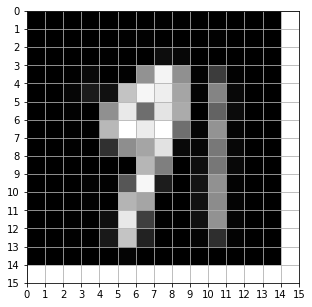

In [51]:
label, img = get_training_data(training_df, pair_index)
zoom_img(img), label

## 1.4 Summary

In this notebook, you have seen how we can use the robot's light sensor as a simple low resolution camera to sample handwritten digit images from the background. Collecting the data from the robot, we can then convert it to an image and preprocess is before testing it with a pre-trained multi-layer perceptron.

Using captured images that are slightly offset from the center of the image array  essentially provides us with a "jiggled" image, which tends to increase the classification error.

You have also seen how we might automate the collection of large amounts of data by "teleporting" the robot to particular locations and sampling the data. With the background defined as it is, we can also pick up encoded label data an use this to generate training data made up of scanned handwritten digit and image label pairs. In principle, we could use the image and test label data collected in this way as a training data set for an MLP or convolutional neural network.